---
title: Efek Kausal Pendidikan Tinggi terhadap Partisipasi Kerja Wanita (AS, 1975)
description: Analisis kausal untuk mengestimasi pengaruh pendidikan tinggi wanita terhadap partisipasi angkatan kerja di AS menggunakan data Mroz 1975 dan metode matching.
author:
  - name: Taruma Sakti Megariansyah
    orcid: 0000-0002-1551-7673
    email: hi@taruma.info
    url: https://dev.taruma.info
abstract: > 
  Studi ini menganalisis hubungan kausal antara pendidikan tinggi wanita dan partisipasi mereka dalam tenaga kerja menggunakan data Mroz dari Panel Study of Income Dynamics (PSID) tahun 1975. Dengan menggunakan data observasional dari 753 wanita menikah berusia 30-60 tahun, analisis ini menerapkan metode matching untuk mengestimasi efek kausal dari pendidikan tinggi terhadap probabilitas partisipasi dalam tenaga kerja, sambil mengontrol berbagai faktor confounding seperti usia, pendidikan suami, jumlah anak, dan pendapatan keluarga.

  Hasil analisis menggunakan berbagai metode matching menunjukkan efek kausal yang positif dan signifikan. Distance matching dengan one-to-one specification menghasilkan Average Treatment Effect (ATE) sebesar 25 percentage points (p = 0.001), sementara propensity score matching setelah trimming mengestimasi efek sebesar 28.2 percentage points (p < 0.001). Konsistensi hasil dari berbagai spesifikasi matching memberikan bukti kuat bahwa pendidikan tinggi secara substansial meningkatkan probabilitas partisipasi wanita dalam tenaga kerja.
keywords:
  - Causal Inference
  - Matching
  - Data Mroz
  - Partisipasi Tenaga Kerja Wanita
  - Pendidikan Tinggi
  - Algoritma-DSS
license: "CC BY"
copyright: 
  holder: Taruma Sakti Megariansyah
  year: 2024
date: 2024-11-21
date-modified: last-modified
date-format: full
format:
    html:
        code-fold: true
        number-sections: true
        toc-title: Daftar Isi
        other-links:
        - text: My Github
          icon: github
          href: https://github.com/taruma
        - text: My Other Projects
          icon: journals
          href: https://dev.taruma.info/projects
        - text: Sponsor Me
          icon: heart
          href: https://github.com/sponsors/taruma
        - text: Buy Me a Drink
          icon: cup-straw
          href: https://trakteer.id/taruma/tip
        code-links:
        - text: Repository
          icon: github
          href: https://github.com/taruma/causal-mroz
        - text: Source Code
          icon: code
          href: https://github.com/taruma/causal-mroz/blob/main/causal_mroz.ipynb
        theme: flatly
        toc: true
        toc-location: left
        toc-expand: 2
        toc-depth: 4
        embed-resources: true
include-in-header: # from: https://github.com/quarto-dev/quarto-cli/discussions/4618
  - text: |
      <link rel = "shortcut icon" href = "favicon-ti.png" />
execute:
  enabled: false
citation: 
  url: https://dev.taruma.info/causal-mroz/causal_mroz.html
lightbox: auto
lang: id
title-block-banner: banner.png
# title-block-banner-color: black
---

Pernah dengar ungkapan "korelasi bukan berarti hubungan sebab-akibat"? Meskipun dua hal terjadi bersamaan, belum tentu satu menyebabkan yang lain. Nah, di sinilah _causal inference_ berperan. _Causal inference_ membantu kita memahami bukan hanya apa yang terjadi, tetapi mengapa hal itu terjadi. Ini seperti menjadi detektif data, mencari petunjuk untuk mengungkap hubungan sebab-akibat yang sebenarnya, bukan hanya melihat kebetulan belaka.

Pada lembar kerja ini, data Mroz akan digunakan untuk mengilustrasikan penerapan teknik causal inference dalam memahami partisipasi tenaga kerja wanita di AS. Proses analisis akan meliputi perancangan diagram kausal untuk memvisualisasikan hubungan antar variabel, eksplorasi data untuk mengidentifikasi pola dan karakteristik penting, serta pemodelan statistik yang sesuai untuk mengisolasi dan mengukur efek kausal. Fokus utama adalah pada pengungkapan faktor-faktor yang secara kausal memengaruhi keputusan seorang wanita untuk bekerja atau tidak, analisis korelasi sederhana dengan menguji hubungan sebab-akibat antara variabel-variabel seperti jumlah anak, pendidikan, pendapatan suami, dan upah yang diharapkan.

::: {.callout-important}
## Lembar Kerja Pembelajaran

Lembar kerja ini dibuat sebagai bagian dari proses pembelajaran saya dalam mengikuti program _Data Science Series: Causal Inference for Business Decisions: Understanding Cause & Effect_ yang diselenggarakan oleh Algoritma pada tanggal 11-14 November 2024. Oleh karena itu, kemungkinan terdapat ketidakakuratan atau kesalahan dalam analisis dan kesimpulan yang disajikan. Umpan balik dan koreksi sangat dihargai, Anda dapat menyampaikannya melalui [isu github disini](https://github.com/taruma/causal-morz/issues/new). 
:::

## Pengaturan Awal

::: {.callout-note .column-margin}
Versi python yang digunakan adalah versi `3.11`. Pastikan membaca [`README.md`](https://github.com/taruma/causal-mroz#causal-morz) untuk menjalankan notebook ini.
:::

Pada bagian ini akan dilakukan pengaturan untuk lembar kerja dan mengambil dataset `Mroz` dari paket `causaldata`.

In [1]:
# SETUP
import causaldata
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel
from causalinference import CausalModel
from IPython.display import display, Markdown # noqa: F401

data_mroz = causaldata.Mroz.load_pandas().data

::: {.callout-caution collapse="true"}
## Output informasi dari data `Mroz`

**Output `causaldata.Mroz.TITLE`:**

`{python} Markdown(causaldata.Mroz.TITLE.replace('\n', '<br>'))` 

**Output `causaldata.Mroz.DESCRSHORT`:**

`{python} Markdown(causaldata.Mroz.DESCRSHORT.replace('\n', '<br>'))` 

**Output `causaldata.Mroz.DESCRLONG`:**

`{python} Markdown(causaldata.Mroz.DESCRLONG.replace('\n', '<br>'))` 

**Output `causaldata.Mroz.NOTE`:**

`{python} Markdown(causaldata.Mroz.NOTE.replace('\n', '<br>'))` 

**Output `causaldata.Mroz.SOURCE`:**

`{python} Markdown(causaldata.Mroz.SOURCE.replace('\n', '<br>'))` 
:::

## Data **Mroz**

Berdasarkan penjelasan singkat yang diperoleh dari `causaldata.Mroz`, Data **Mroz** merupakan sebuah dataset _cross-sectional_ dari tahun 1975 yang berisi informasi tentang partisipasi tenaga kerja wanita di Amerika Serikat. Data ini dikumpulkan oleh Thomas A. Mroz sebagai bagian dari Panel Study of Income Dynamics (PSID).

In [2]:
#| label: tbl-sample
#| tbl-cap: Sampel dataset Mroz

# Clean up column names and show a sample of the data
df_mroz = data_mroz.set_index(data_mroz.columns[0]).rename_axis('no')
df_mroz.sample(5)

,lfp,k5,k618,age,wc,hc,lwg,inc
no,,,,,,,,
126,True,0,2,35,False,False,-1.822531,17.900000
129,True,0,1,54,True,False,0.864858,16.142000
228,True,1,2,34,True,True,1.799216,28.199999
87,True,0,0,59,True,True,1.129865,10.500000
338,True,0,2,40,False,False,1.475907,17.900000


In [3]:
#| column: margin

# Information about the dataset
df_mroz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753 entries, 1 to 753
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lfp     753 non-null    bool   
 1   k5      753 non-null    int64  
 2   k618    753 non-null    int64  
 3   age     753 non-null    int64  
 4   wc      753 non-null    bool   
 5   hc      753 non-null    bool   
 6   lwg     753 non-null    float64
 7   inc     753 non-null    float64
dtypes: bool(3), float64(2), int64(3)
memory usage: 37.5 KB


Dari sampel data (@tbl-sample) dan informasi data **Mroz**, berikut informasi yang dapat diambil:

- Data **Mroz** terdiri dari $753$ observasi/baris dan $8$ variabel. Dan tidak ada nilai yang hilang karena seluruh variabel memberikan informasi `753 non-null` (sejumlah dengan observasi). 
- **lfp (Labor-force participation):** Variabel biner yang menunjukkan apakah seorang wanita berpartisipasi dalam tenaga kerja (1) atau tidak (0). Inilah variabel outcome (Y) yang ingin kita pahami.
- **k5 (Number of children 5 years old or younger):** Jumlah anak berusia 5 tahun atau lebih muda.
- **k618 (Number of children 6 to 17 years old):** Jumlah anak berusia 6 hingga 17 tahun.
- **age:** Usia wanita dalam tahun.
- **wc (Wife attended college):** Variabel biner yang menunjukkan apakah istri berkuliah (1) atau tidak (0).
- **hc (Husband attended college):** Variabel biner yang menunjukkan apakah suami berkuliah (1) atau tidak (0).
- **lwg (Log expected wage rate):** Logaritma dari tingkat upah yang diharapkan. Untuk wanita yang bekerja, ini adalah tingkat upah aktual; untuk wanita yang tidak bekerja, ini adalah nilai yang diimputasi berdasarkan regresi lwg pada variabel lain.
- **inc (Family income exclusive of wife’s income):** Pendapatan keluarga tidak termasuk pendapatan istri.

Karena data Mroz merupakan data observational, yaitu data yang dikumpulkan tanpa intervensi atau manipulasi langsung oleh peneliti, maka _Randomized Controlled Trial (RCT)_ tidak sesuai untuk kasus ini. Sebagai alternatif, digunakan _Quasi-Experimental Approach_, dimana menganalisis data yang sudah ada dan berupaya mengisolasi hubungan sebab-akibat dengan memanfaatkan variasi yang terjadi secara alami dan teknik statistik untuk memperhitungkan faktor-faktor lain yang berpengaruh. Sehingga penggunaan _Quasi-Experimental Approach_ merupakan pendekatan yang sesuai dengan kasus ini.

## Tujuan dan Hipotesis Kausal

Bagian ini menjelaskan tujuan analisis dan hipotesis kausal yang akan diuji. Mengingat data Mroz merupakan data observasional, fokusnya adalah mengungkap hubungan sebab-akibat antara variabel-variabel yang ada, khususnya pengaruh **pendidikan wanita** terhadap **partisipasinya dalam tenaga kerja** di AS.

### Tujuan

Tujuan utama dari analisis ini adalah untuk mengestimasi efek kausal dari pendidikan tinggi wanita (`wc`) terhadap partisipasinya dalam tenaga kerja (`lfp`), dengan mempertimbangkan variabel-variabel lain yang mungkin menjadi *confounder*. Secara spesifik, analisis ini ingin menjawab pertanyaan: **Apakah seorang wanita yang berkuliah (perguruan tinggi) memiliki probabilitas lebih tinggi untuk berpartisipasi dalam tenaga kerja dibandingkan dengan wanita yang tidak berkuliah, setelah memperhitungkan faktor-faktor lain seperti usia, jumlah anak, pendapatan keluarga, dan pendidikan suami?**

### Hipotesis Kausal

Hipotesis nol ($H_0$) dan hipotesis alternatif ($H_1$) dirumuskan sebagai berikut:

- $H_0$: Tidak ada efek kausal dari pendidikan tinggi istri (`wc`) terhadap partisipasinya dalam tenaga kerja (`lfp`), setelah mengontrol variabel *confounding*.
- $H_1$: Terdapat efek kausal dari pendidikan tinggi istri (`wc`) terhadap partisipasinya dalam tenaga kerja (`lfp`), setelah mengontrol variabel *confounding*. Lebih spesifik, dihipotesiskan bahwa istri yang berkuliah memiliki probabilitas lebih tinggi untuk berpartisipasi dalam tenaga kerja.

## Diagram Kausal

Bagian ini bertujuan untuk membangun diagram kausal (Directed Acyclic Graph - DAG) yang merepresentasikan hubungan sebab-akibat antar variabel dalam data Mroz. DAG ini akan menjadi panduan dalam  menganalisis pengaruh pendidikan wanita (*wc*) terhadap partisipasinya dalam tenaga kerja (*lfp*). Perlu dicatat bahwa interpretasi diagram kausal ini ditentukan secara subjektif, sehingga perbedaan perspektif atau pemodelan mungkin terjadi. 

### Identifikasi Variabel

Variabel-variabel yang dipertimbangkan dalam analisis ini, beserta perannya masing-masing, adalah sebagai berikut:

- **lfp (Labor-force participation):** Variabel dependen/outcome (Y) yang menunjukkan partisipasi seorang wanita dalam tenaga kerja (1 = berpartisipasi, 0 = tidak berpartisipasi).
- **wc (Wife attended college):** Variabel treatment/perlakuan (X) yang menunjukkan apakah seorang wanita berkuliah (1) atau tidak (0).
- **age (Age):** Usia wanita, berperan sebagai variabel *confounding* yang berpotensi memengaruhi `wc` dan `lfp`.
- **k5 (Number of children 5 years old or younger):** Jumlah anak berusia 5 tahun atau lebih muda. Diperkirakan memengaruhi `lfp`.
- **k618 (Number of children 6 to 17 years old):** Jumlah anak berusia 6 hingga 17 tahun.  Diperkirakan memengaruhi `lfp`.
- **hc (Husband attended college):**  Pendidikan suami, berpotensi memengaruhi `lfp` dan `inc`.
- **lwg (Log expected wage rate):** Logaritma dari tingkat upah yang diharapkan. Diperkirakan dipengaruhi `wc` dan memengaruhi `lfp`.
- **inc (Family income exclusive of wife’s income):** Pendapatan keluarga (tidak termasuk pendapatan istri). Diperkirakan dipengaruhi `hc` dan memengaruhi `lfp`.

### Pertimbangan dalam Menentukan Hubungan Kausal

Hubungan kausal antar variabel ditentukan berdasarkan pendekatan dan pemahaman saya. Berikut beberapa pertimbangan yang mendasari pembentukan DAG:

* **Pengaruh Usia:** Usia (`age`) diasumsikan memengaruhi pendidikan wanita (`wc`), partisipasi tenaga kerja (`lfp`), dan jumlah anak (`k5` dan `k618`).
* **Pengaruh Pendidikan:** Pendidikan wanita (`wc`) diasumsikan memengaruhi partisipasi tenaga kerja (`lfp`) dan tingkat upah yang diharapkan (`lwg`).
* **Pengaruh Pendidikan Suami:** Pendidikan suami (`hc`) diasumsikan memengaruhi pendapatan keluarga (`inc`) dan, secara tidak langsung, partisipasi istri dalam tenaga kerja (`lfp`).
* **Pengaruh Anak:** Jumlah anak (`k5` dan `k618`) diasumsikan memengaruhi partisipasi wanita dalam tenaga kerja (`lfp`).
* **Pengaruh Pendapatan & Upah:** Pendapatan keluarga (`inc`) dan tingkat upah yang diharapkan (`lwg`) diasumsikan memengaruhi partisipasi wanita dalam tenaga kerja (`lfp`).

### Diagram Kausal (DAG)

Untuk menyederhanakan diagram atau model, dipertimbangan untuk mengabaikan variabel `lwg` dalam penyelesaian Causal Inference dalam lembar kerja ini. Berikut representasi visual dari hubungan kausal yang telah dibahas sebelumnya di atas:

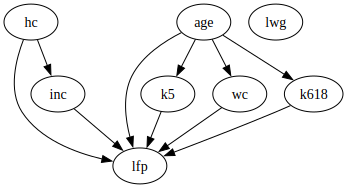

In [4]:
#| label: fig-dag-mroz
#| fig-cap: Diagram Kausal Partisipasi Seorang Wanita dalam Tenaga Kerja
#| fig-scap: DAG Mroz
#| fig-align: center

# Definisikan variabel
variables = df_mroz.columns

# Definisikan edges (hubungan kausal)
edges = [('age', 'wc'), ('age', 'lfp'), ('age', 'k5'), ('age', 'k618'),
         ('wc', 'lfp'), ('hc', 'lfp'), ('hc', 'inc'),
         ('k5', 'lfp'), ('k618', 'lfp'), ('inc', 'lfp')]

# Buat DAG
dag = CausalGraphicalModel(nodes=variables, edges=edges)

# Plot DAG
dag.draw()

Diagram kausal (@fig-dag-mroz) di atas menggambarkan asumsi subjektif tentang hubungan kausal antar variabel dalam data Mroz. Diagram ini menunjukkan bagaimana faktor-faktor seperti usia, jumlah anak, pendidikan suami, dan pendapatan keluarga, bersama dengan pendidikan wanita, dapat memengaruhi partisipasi wanita dalam tenaga kerja. Arah panah mengindikasikan arah hubungan kausal yang diasumsikan. Penting untuk dicatat bahwa DAG ini merupakan representasi hipotesis yang perlu divalidasi lebih lanjut.

## Exploratory Data Analysis

Pada bagian Exploratory Data Analysis (EDA) ini, akan dikaji karakteristik data Mroz untuk memahami pola, distribusi variabel, dan hubungan antar variabel, sebelum melangkah ke analisis kausal. Pemahaman data yang komprehensif melalui EDA krusial untuk membangun model kausal yang akurat dan valid, memvalidasi asumsi, serta memastikan interpretasi yang tepat terhadap efek pendidikan wanita (`wc`) pada partisipasi tenaga kerja (`lfp`). Bagian EDA ini dibagi menjadi dua bagian yaitu statistik deskriptif dan visualisasi datanya. 

### Statistik Deskriptif

Statistik deskriptif merupakan langkah awal yang penting dalam analisis data karena memberikan gambaran umum tentang karakteristik data yang digunakan. Dengan menghitung statistik deskriptif,  dapat diperoleh informasi mengenai distribusi data, ukuran pemusatan data (seperti mean, median, dan modus), serta ukuran penyebaran data (seperti standar deviasi, range, dan kuartil). Informasi ini membantu  memahami pola-pola dasar dalam data, mengidentifikasi potensi outlier, dan membentuk hipotesis awal sebelum melanjutkan ke analisis yang lebih kompleks.  Statistik deskriptif juga berguna untuk mengkomunikasikan temuan secara ringkas dan mudah dipahami.


#### Data Numerikal

Untuk memahami karakteristik numerik dalam dataset,  langkah selanjutnya adalah menganalisis  statistik deskriptif variabel-variabel numerik.  Analisis ini akan memberikan gambaran tentang distribusi, ukuran pemusatan, dan penyebaran data.

In [5]:
#| column: margin

# Information about the dataset
df_mroz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753 entries, 1 to 753
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lfp     753 non-null    bool   
 1   k5      753 non-null    int64  
 2   k618    753 non-null    int64  
 3   age     753 non-null    int64  
 4   wc      753 non-null    bool   
 5   hc      753 non-null    bool   
 6   lwg     753 non-null    float64
 7   inc     753 non-null    float64
dtypes: bool(3), float64(2), int64(3)
memory usage: 37.5 KB


In [6]:
#| label: tbl-describe
#| tbl-cap: Deskripsi Statistik Mroz

df_mroz.describe()

,k5,k618,age,lwg,inc
count,753.000000,753.000000,753.000000,753.000000,753.000000
mean,0.237716,1.353254,42.537849,1.097115,20.128965
std,0.523959,1.319874,8.072574,0.587556,11.634799
min,0.000000,0.000000,30.000000,-2.054124,-0.029000
25%,0.000000,0.000000,36.000000,0.818087,13.025000
50%,0.000000,1.000000,43.000000,1.068403,17.700001
75%,0.000000,2.000000,49.000000,1.399717,24.466000
max,3.000000,8.000000,60.000000,3.218876,96.000000


Output `df_mroz.describe()` pada @tbl-describe menampilkan ringkasan statistik deskriptif untuk variabel numerik dalam dataset Mroz. Berikut insight yang dapat diperoleh:

::: {.callout-warning .column-margin title="Nilai negatif di `inc` income"} 

Nilai minimum inc yang negatif (mungkin disebabkan kesalahan pencatatan, kerugian bisnis/investasi, utang, atau subsidi negatif) dianggap sebagai kerugian bisnis/investasi atau utang untuk analisis awal. Evaluasi lebih lanjut mungkin memerlukan penghapusan observasi atau transformasi data, namun hal ini akan dipertimbangkan setelah analisis awal.

:::

- **k5 (Number of children 5 years old or younger):** Rata-rata jumlah anak berusia 5 tahun ke bawah adalah 0.24, menandakan sebagian besar wanita dalam sampel memiliki sedikit atau tidak ada anak dalam rentang usia ini. Nilai maksimum 3 menunjukkan beberapa outlier dengan jumlah anak yang lebih banyak.
- **k618 (Number of children 6 to 17 years old):** Rata-rata jumlah anak berusia 6 hingga 17 tahun adalah 1.35, lebih tinggi daripada k5. Nilai maksimum 8 menunjukkan potensi outlier.
- **age (Age):** Usia rata-rata wanita dalam sampel adalah 42.5 tahun, dengan rentang usia antara 30 hingga 60 tahun. Distribusi usia tampaknya cukup merata, ditunjukkan oleh nilai median (43) yang dekat dengan rata-rata.
- **lwg (Log expected wage rate):** Rata-rata `lwg` adalah 1.10, dengan standar deviasi 0.59. Perhatikan nilai minimum -2.05, yang perlu diselidiki lebih lanjut. Karena `lwg` adalah logaritma, nilai negatif mengindikasikan tingkat upah yang diharapkan sangat rendah.
- **inc (Family income exclusive of wife’s income):** Pendapatan keluarga rata-rata (tidak termasuk pendapatan istri) adalah 20.13, dengan standar deviasi yang relatif tinggi yaitu 11.63, mengindikasikan variasi pendapatan yang cukup besar dalam sampel. Nilai maksimum 96 jauh lebih tinggi daripada nilai lainnya, menandakan adanya outlier.

Alasan hanya variabel-variabel ini yang muncul dalam output `data.describe()` adalah karena fungsi tersebut hanya menghitung statistik deskriptif untuk variabel numerik. Variabel lain dalam dataset Mroz, seperti `lfp`, `wc`, dan `hc`, adalah variabel kategorikal (biner dalam hal ini) yang direpresentasikan sebagai integer (0 atau 1). Meskipun direpresentasikan sebagai angka, variabel-variabel ini tidak memiliki arti numerik dalam konteks perhitungan mean, standar deviasi, dsb. Untuk variabel kategorikal, analisis frekuensi dan proporsi akan lebih informatif.


#### Data Kategorikal

Analisis deskriptif untuk data kategorikal, seperti lfp, wc, dan hc dalam data Mroz, berfokus pada proporsi atau frekuensi setiap kategori. Berbeda dengan data numerik yang dapat dirangkum dengan rata-rata atau standar deviasi, data kategorikal membutuhkan pendekatan yang berbeda karena merepresentasikan kelompok atau kualitas, bukan kuantitas. Kita akan menganalisis proporsi setiap kategori untuk memahami distribusi variabel-variabel ini.

In [7]:
#| label: tbl-prop
#| tbl-cap: "Tabel Proporsi Kategorikal"
#| tbl-subcap:
#|  - "Jumlah Data Kategorikal"
#|  - "Proporsi Data Kategorikal"
#| layout-ncol: 2

# Calculate counts and proportions
counts = pd.DataFrame({
    'lfp': df_mroz['lfp'].value_counts(),
    'wc': df_mroz['wc'].value_counts(),
    'hc': df_mroz['hc'].value_counts()
})

props = pd.DataFrame({
    'lfp': df_mroz['lfp'].value_counts(normalize=True),
    'wc': df_mroz['wc'].value_counts(normalize=True), 
    'hc': df_mroz['hc'].value_counts(normalize=True)
})

# Transpose DataFrames
counts = counts.T
props = (props.T*100).map('{:.2f}%'.format)
counts.columns = ['0_count', '1_count']
props.columns = ['0_prop', '1_prop']

display(counts)
display(props)

,0_count,1_count
lfp,325,428
wc,541,212
hc,458,295


,0_prop,1_prop
lfp,43.16%,56.84%
wc,71.85%,28.15%
hc,60.82%,39.18%


@tbl-prop memberikan informasi berharga tentang distribusi variabel kategorikal dalam dataset Mroz. Berikut analisis yang dapat ditarik:

**1. Partisipasi tenaga kerja (`lfp`):**

- **Mayoritas Berpartisipasi:** Tabel 2 menunjukkan bahwa 56.84% wanita dalam sampel berpartisipasi dalam tenaga kerja (`lfp` = 1). Ini menunjukkan bahwa lebih banyak wanita dalam sampel yang bekerja atau aktif mencari pekerjaan dibandingkan yang tidak.

**2. Pendidikan Wanita (`wc`):**

- **Sebagian Besar Tidak Kuliah:** Sebagian besar wanita dalam sampel (71.85%) tidak berkuliah (`wc` = 0). Hanya 28.15% yang pernah kuliah. Ini mengindikasikan bahwa pendidikan tinggi di kalangan wanita masih relatif rendah pada saat data dikumpulkan (1975).

**3. Pendidikan Suami (`hc`):**

- **Pendidikan Suami Lebih Tinggi:** Proporsi suami yang berkuliah (`hc` = 1) lebih tinggi daripada istri (39.18% vs. 28.15%). Ini menunjukkan adanya kesenjangan pendidikan antara suami dan istri pada masa itu.

**Implikasi untuk Analisis Kausal:**

- **Efek `wc` terhadap `lfp`:** Proporsi yang ditunjukkan dalam tabel-tabel ini menjadi *baseline* yang penting. Analisis kausal selanjutnya akan menguji apakah terdapat perbedaan yang signifikan dalam partisipasi tenaga kerja (`lfp`) antara wanita yang kuliah (`wc` = 1) dan yang tidak (`wc` = 0), *setelah mengontrol confounding variables*.
- **Potensi Confounder:** Perbedaan proporsi dalam `hc` menunjukkan bahwa pendidikan suami bisa menjadi *confounder* potensial dalam hubungan antara `wc` dan `lfp`. Artinya, pendidikan suami dapat memengaruhi baik pendidikan istri maupun partisipasinya dalam tenaga kerja. 

#### Tabel Kontingensi (_Cross-Tabulation_)

Analisis data dalam studi kausalitas, khususnya yang menggunakan data observasional seperti data Mroz, memerlukan pemahaman menyeluruh tentang hubungan antar variabel. Salah satu metode eksplorasi awal yang efektif adalah pembuatan tabel kontingensi atau *cross-tabulation*. Tahapan ini penting untuk memvisualisasikan hubungan antara variabel-variabel kategorikal, terutama antara variabel perlakuan (treatment) dan outcome, serta variabel-variabel lain yang berpotensi menjadi *confounder*. Dengan tabel kontingensi, kita dapat mengidentifikasi pola hubungan, membandingkan proporsi antar subkelompok, dan memperoleh gambaran awal tentang potensi efek kausal, yang selanjutnya akan menjadi dasar bagi analisis dan pemodelan kausal yang lebih lanjut. Selain itu, tabel kontingensi juga membantu dalam memvalidasi asumsi-asumsi yang mendasari diagram kausal (DAG) yang telah dibangun sebelumnya (@fig-dag-mroz).


In [8]:
#| label: tbl-crosstab
#| tbl-cap: "Tabel Kontingensi"
#| tbl-subcap:
#|  - "lfp vs. wc"
#|  - "lfp vs. wc (Proporsi)"
#|  - "lfp vs. hc"
#|  - "lfp vs. hc (Proporsi)"
#|  - "wc vs. hc"
#|  - "wc vs. hc (Proporsi)"
#| layout-ncol: 2
#| layout-nrow: 3

# Fungsi menghitung tabel kontingensi dan proporsi per baris
def calc_crosstab(data, var1, var2):
    """Menghitung tabel kontingensi dan proporsi per baris"""
    table = pd.crosstab(data[var1].astype(int), data[var2].astype(int))
    prop_table = (table.div(table.sum(axis=1), axis=0) * 100).map('{:.2f}%'.format)
    return table, prop_table

# lfp vs. wc
table1, prop_table1 = calc_crosstab(df_mroz, 'lfp', 'wc')

# lfp vs. hc
table2, prop_table2 = calc_crosstab(df_mroz, 'lfp', 'hc')

# wc vs. hc
table3, prop_table3 = calc_crosstab(df_mroz, 'wc', 'hc')

display(table1)
display(prop_table1)
display(table2)
display(prop_table2)
display(table3)
display(prop_table3)


wc,0,1
lfp,,
0,257,68
1,284,144


wc,0,1
lfp,,
0,79.08%,20.92%
1,66.36%,33.64%


hc,0,1
lfp,,
0,207,118
1,251,177


hc,0,1
lfp,,
0,63.69%,36.31%
1,58.64%,41.36%


hc,0,1
wc,,
0,417,124
1,41,171


hc,0,1
wc,,
0,77.08%,22.92%
1,19.34%,80.66%


Berdasarkan hasil tabel kontingensi (@tbl-crosstab), beberapa _insight_ penting yang dapat diidentifikasi:

1. **Hubungan `lfp` dan `wc` (Outcome vs Treatment)**:
  - Dari wanita yang berpartisipasi dalam tenaga kerja (`lfp=1`), 33.64% memiliki pendidikan tinggi, lebih tinggi dibandingkan dengan yang tidak berpartisipasi (20.92%). (@tbl-crosstab-2).
  - Hal ini mengindikasikan adanya asosiasi positif antara pendidikan tinggi dengan partisipasi tenaga kerja.

2. **Hubungan `lfp` dan `hc` (Outcome vs Potential Confounder)**:
  - Terdapat perbedaan proporsi yang lebih kecil namun tetap terlihat: 41.36% wanita yang berpartisipasi dalam tenaga kerja memiliki suami dengan pendidikan tinggi, dibandingkan dengan 36.31% untuk yang tidak berpartisipasi. (@tbl-crosstab-4)
  - Ini menunjukkan bahwa pendidikan suami (`hc`) mungkin memiliki pengaruh terhadap partisipasi kerja istri, meskipun efeknya tidak sekuat pendidikan istri sendiri.

3. **Hubungan `wc` dan `hc` (Treatment vs Potential Confounder)**:
  - Terdapat asosiasi yang sangat kuat antara pendidikan istri dan suami: 80.66% wanita yang berkuliah memiliki suami yang juga berkuliah. (@tbl-crosstab-6)
  - Hal ini mengindikasikan adanya *assortative mating* (kecenderungan menikah dengan pasangan yang memiliki tingkat pendidikan serupa).
  - Hubungan yang kuat ini mengkonfirmasi bahwa `hc` merupakan *confounder* penting yang perlu dikontrol dalam analisis kausal.

Insight-insight ini mendukung pentingnya mengontrol variabel pendidikan suami (`hc`) dalam analisis kausal untuk mengestimasi efek murni dari pendidikan wanita terhadap partisipasi tenaga kerja.

### Visualisasi Data

Setelah mengeksplorasi statistik deskriptif dan tabel kontingensi, langkah selanjutnya adalah memvisualisasikan data untuk mendapatkan pemahaman yang lebih mendalam tentang pola dan hubungan antar variabel dalam data Mroz. Visualisasi data memberikan representasi grafis yang dapat membantu mengidentifikasi tren, outlier, dan hubungan yang mungkin tidak terlihat jelas dari angka-angka statistik semata. Visualisasi juga membantu dalam mengomunikasikan temuan dengan cara yang lebih intuitif dan mudah dipahami.

#### Pairplot

Visualisasi menggunakan pairplot merupakan langkah awal yang efisien dalam eksplorasi data Mroz karena mampu menampilkan distribusi setiap variabel dan hubungan antar variabel secara simultan dalam satu tampilan. Dengan pembedaan warna berdasarkan partisipasi tenaga kerja (`lfp`), pairplot membantu mengidentifikasi pola, outlier, dan potensi hubungan yang relevan untuk analisis kausal selanjutnya.

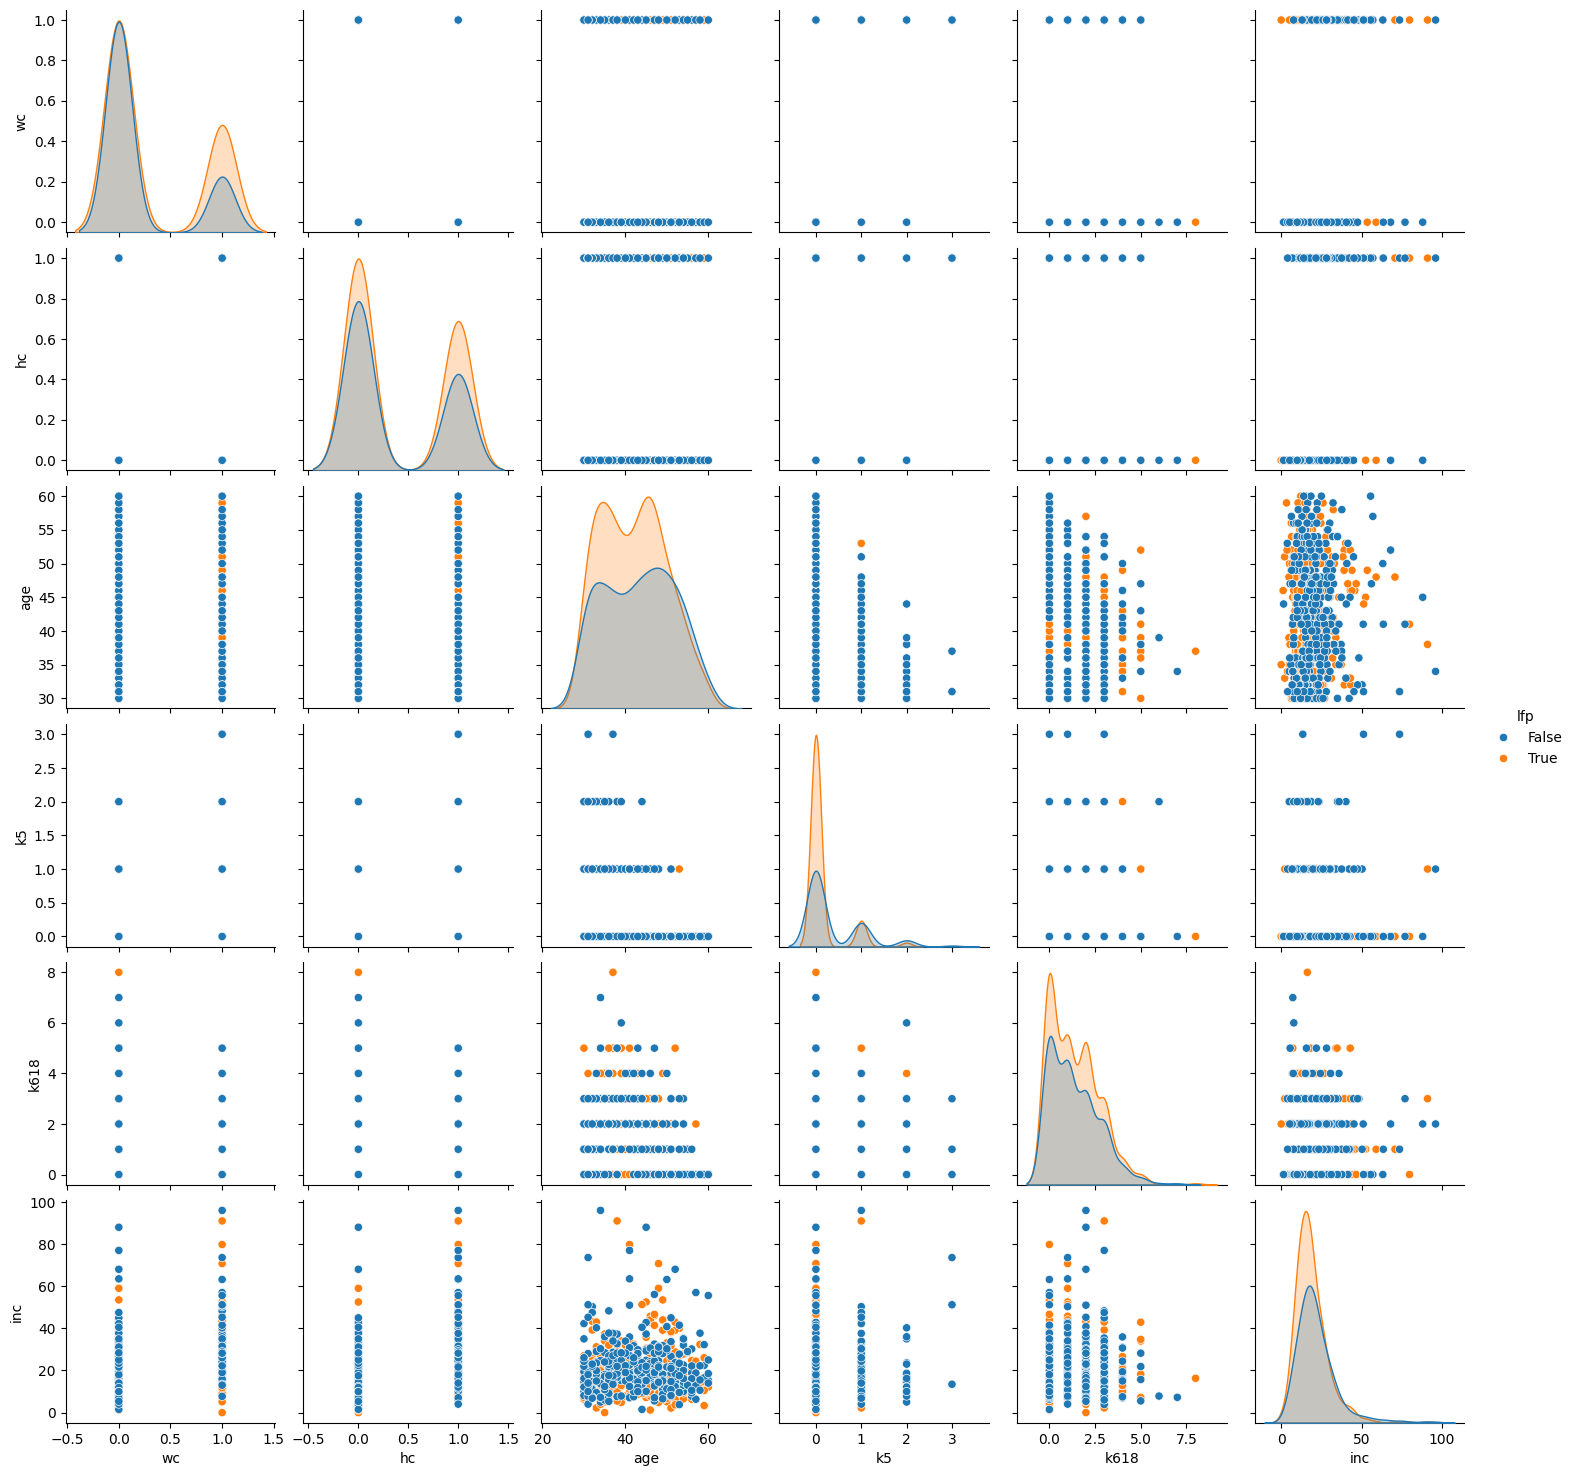

In [9]:
#| label: fig-pairplot
#| fig-cap: Pairplot Mroz
#| column: page-inset-right

sns.pairplot(df_mroz[['wc', 'hc', 'lfp', 'age', 'k5', 'k618', 'inc']], hue='lfp');

Berdasarkan visualisasi pairplot yang ditampilkan (@fig-pairplot), berikut insight yang dapat diperoleh dari grafik pairplot:

##### Analisis Variabel Kategorikal (`wc`, `hc`, `lfp`)

- Distribusi `wc` (Wife attended college) menunjukkan dua puncak yang berbeda, dengan proporsi yang lebih tinggi untuk wanita yang tidak kuliah (0) dibandingkan yang kuliah (1). Ini konsisten dengan statistik deskriptif yang menunjukkan 71.85% wanita tidak berkuliah (@tbl-prop-2).
- Pola serupa terlihat pada `hc` (Husband attended college), namun dengan proporsi yang lebih seimbang, sesuai dengan statistik bahwa 39.18% suami memiliki pendidikan tinggi (@tbl-prop-2).

##### Analisis Variabel Numerik

**Usia (`age`):**

- Distribusi usia menunjukkan pola bimodal dengan dua puncak di sekitar usia 35-40 dan 45-50 tahun.
- Range usia 30-60 tahun terlihat jelas pada plot, sesuai dengan statistik deskriptif (@tbl-describe).
- Tidak terlihat banyak outlier yang signifikan dalam variabel usia.

**Jumlah Anak (`k5` dan `k618`):**

- Pola ini konsisten dengan statistik deskriptif yang menunjukkan rata-rata `k5` = 0.24 dan `k618` = 1.35 (@tbl-describe).

**Pendapatan (`inc`):**

- Terlihat beberapa outlier di atas 60-80, sesuai dengan nilai maksimum 96 pada statistik deskriptif. (@tbl-describe)
- Mayoritas pendapatan terkonsentrasi di bawah 40.

##### Hubungan Antar Variabel

**Pendidikan dan Partisipasi Kerja:**

- Terlihat pola positif antara `wc` dan `lfp`, dimana wanita dengan pendidikan tinggi cenderung lebih berpartisipasi dalam tenaga kerja.
- Hubungan serupa juga terlihat antara `hc` dan `lfp`, meskipun tidak sekuat hubungan `wc-lfp`.

Visualisasi ini memperkuat pemahaman tentang struktur data dan mendukung asumsi-asumsi yang dibuat dalam diagram kausal (DAG) (@fig-dag-mroz) dan [bab statistik deskriptif](#statistik-deskriptif) sebelumnya.

#### Histogram

Untuk memahami karakteristik sampel dan pola hubungan antar variabel, berikut disajikan histogram yang menggambarkan distribusi usia, jumlah anak, dan pendapatan keluarga, di mana setiap variabel dikelompokkan berdasarkan status partisipasi kerja wanita.

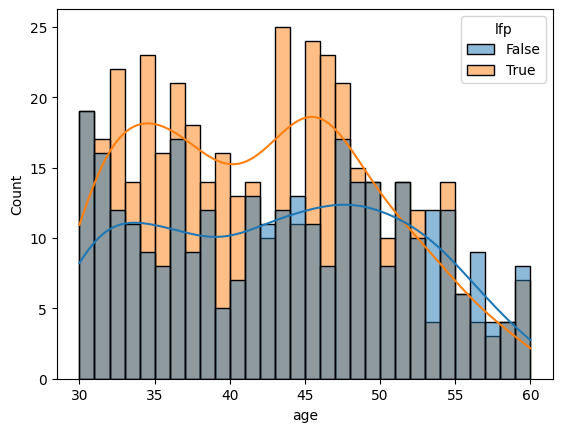

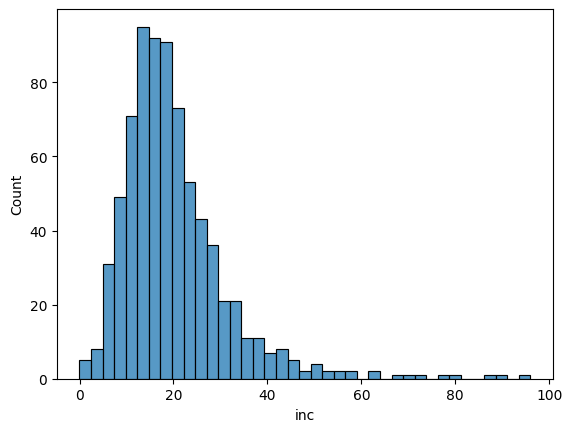

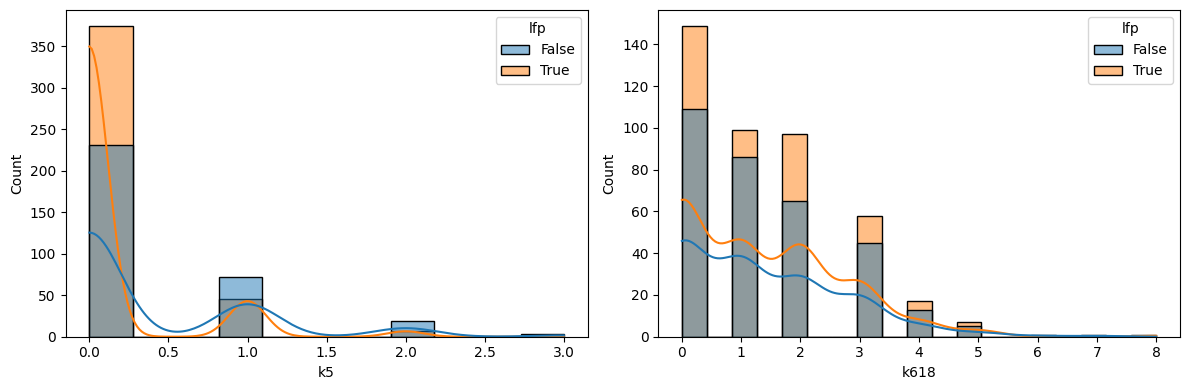

In [10]:
#| label: fig-histplot
#| fig-cap: Visualisasi Histogram terhadap berbagai variabel
#| fig-subcap:
#|   - "Usia"
#|   - "Pendapatan"
#|   - "Jumlah Anak"
#| fig-align: center
#| layout: [[1,1], [1]]
#| align: center


sns.histplot(
    data=df_mroz, x="age", hue="lfp", multiple="layer", alpha=0.5, bins=30, kde=True
)
plt.show()

sns.histplot(data=df_mroz, x='inc')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Plot untuk k5
sns.histplot(
    data=df_mroz, x="k5", hue="lfp", multiple="layer", kde=True, alpha=0.5, ax=ax1
)

# Plot untuk k618
sns.histplot(
    data=df_mroz, x="k618", hue="lfp", multiple="layer", kde=True, alpha=0.5, ax=ax2
)
plt.tight_layout()
plt.show()



Berdasarkan visualisasi histogram yang ditampilkan, berikut analisis dari setiap variabel:

##### Distribusi Usia (@fig-histplot-1)

- Distribusi usia menunjukkan pola bimodal dengan dua puncak: sekitar usia 35 tahun dan 45 tahun.
- Wanita yang berpartisipasi dalam tenaga kerja (warna oranye) memiliki proporsi yang lebih tinggi di kelompok usia 35-45 tahun.
- Partisipasi kerja cenderung menurun setelah usia 50 tahun, ditunjukkan oleh proporsi oranye yang berkurang.
- Range usia sampel adalah 30-60 tahun, sesuai dengan statistik deskriptif sebelumnya. (@tbl-describe)

##### Jumlah Anak (@fig-histplot-3)

**a) Anak ≤ 5 tahun (`k5`):**
- Mayoritas wanita (>300 observasi) tidak memiliki anak balita (k5 = 0)
- Di antara wanita yang memiliki anak balita, partisipasi kerja (oranye) cenderung lebih rendah
- Sangat sedikit wanita yang memiliki lebih dari 2 anak balita

**b) Anak 6-18 tahun (`k618`):**
- Distribusi lebih menyebar dibanding k5, dengan range 0-8 anak
- Terdapat pola yang menarik dimana proporsi wanita bekerja (oranye) relatif stabil di berbagai jumlah anak
- Mayoritas keluarga memiliki 1-2 anak usia sekolah

##### Pendapatan Keluarga (@fig-histplot-2)

- Distribusi pendapatan menunjukkan positive skewness yang kuat
- Mayoritas pendapatan keluarga terkonsentrasi di rentang 10-30.
- Terdapat beberapa outlier dengan pendapatan di atas 60.

Visualisasi ini memperkuat pemahaman tentang struktur data sebelumnya dan membantu mengidentifikasi variabel-variabel yang perlu dikontrol dalam analisis kausal hubungan antara pendidikan wanita (wc) dan partisipasi kerja (lfp).

#### Correlation Matrix

Untuk melengkapi analisis sebelumnya, correlation matrix digunakan untuk memvisualisasikan dan mengukur kekuatan hubungan linear antar variabel dalam data Mroz. Meskipun korelasi tidak mengimplikasikan kausalitas, pola yang terungkap dapat membantu memvalidasi struktur kausal yang telah dihipotesiskan dalam DAG.

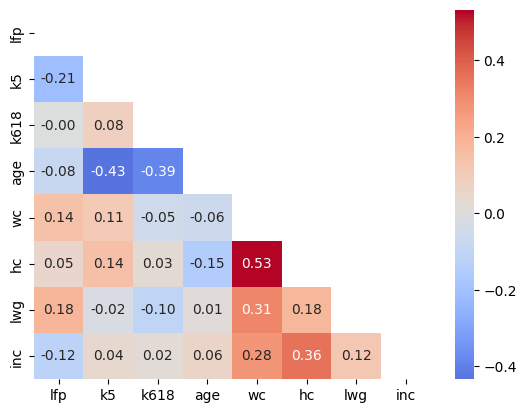

In [11]:
#| label: fig-corr
#| fig-cap: Visualisasi Korelasi antar variabel
#| fig-align: center

corr = df_mroz.corr()
mask = np.triu(np.ones_like(corr)) # untuk menampilkan hanya setengah matriks
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, center=0, fmt=".2f");

Berdasarkan correlation matrix yang ditampilkan di @fig-corr, beberapa pola penting dapat diidentifikasi yang memperkuat dan melengkapi analisis sebelumnya:

##### Hubungan Treatment-Outcome

- Terdapat korelasi positif lemah antara pendidikan wanita (`wc`) dengan partisipasi kerja (`lfp`) sebesar 0.14.
- Temuan ini konsisten dengan hasil tabel kontingensi sebelumnya yang menunjukkan wanita berpendidikan tinggi memiliki kecenderungan lebih besar untuk berpartisipasi dalam tenaga kerja (@tbl-crosstab).

##### Konfirmasi Confounding

- Korelasi kuat antara pendidikan suami (`hc`) dan pendidikan istri (`wc`) sebesar 0.53 mendukung temuan sebelumnya tentang *assortative mating*.
- Hal ini mengkonfirmasi pentingnya mengontrol `hc` sebagai confounder dalam analisis kausal.

##### Pengaruh Karakteristik Keluarga

- Jumlah anak balita (`k5`) berkorelasi negatif dengan partisipasi kerja (`lfp`) sebesar -0.21, menunjukkan bahwa semakin banyak anak kecil, semakin rendah kemungkinan ibu bekerja.
- Menariknya, anak usia 6-17 tahun (`k618`) hampir tidak memiliki korelasi dengan partisipasi kerja (korelasi -0.00).

##### Faktor Ekonomi

- Pendapatan keluarga (`inc`) berkorelasi positif dengan pendidikan suami (`hc`) sebesar 0.36, mendukung struktur DAG yang menghubungkan kedua variabel ini.

##### Validasi DAG

- Pola korelasi secara umum mendukung struktur kausal yang dihipotesiskan dalam DAG (@fig-dag-mroz).
- Khususnya, hubungan antara `wc`, `hc`, dan `inc` sesuai dengan jalur kausal yang diusulkan.

Temuan-temuan ini memperkuat pemahaman tentang kompleksitas hubungan antar variabel dalam data Mroz dan memberikan dasar empiris untuk analisis kausal selanjutnya.

## Pemodelan _Causal Inference_

Setelah melakukan eksplorasi data, ditemukan beberapa pola penting dalam dataset Mroz. Hasil visualisasi dan statistik deskriptif menunjukkan adanya asosiasi positif antara pendidikan wanita (`wc`) dengan partisipasi kerja (`lfp`), dimana 33.64% wanita yang bekerja memiliki pendidikan tinggi dibandingkan hanya 20.92% pada wanita yang tidak bekerja (@tbl-crosstab-2). Selain itu, ditemukan korelasi kuat (0.53) antara pendidikan suami (`hc`) dan istri (`wc`), serta pengaruh negatif dari jumlah anak balita terhadap partisipasi kerja (korelasi -0.21) (@fig-corr). Pada bagian ini akan dilakukan pemodelan kausal untuk mengestimasi efek murni dari pendidikan wanita terhadap partisipasi kerja, dengan mengontrol berbagai faktor confounding yang telah teridentifikasi.

Pemodelan yang digunakan dalam bagian ini adalah metode _Matching_, khususnya _Distance Matching_ dan _Propensity Score Matching_. Pemilihan metode ini didasarkan pada karakteristik data Mroz yang bersifat observasional, di mana terdapat potensi selection bias dan confounding yang signifikan. Matching memungkinkan kita untuk membandingkan outcome (`lfp`) antara wanita yang berkuliah dan tidak berkuliah dengan karakteristik yang serupa, sehingga dapat mengurangi bias dan menghasilkan estimasi efek kausal yang lebih akurat. Metode ini juga sesuai dengan struktur DAG yang telah diidentifikasi sebelumnya, di mana terdapat beberapa variabel confounding yang perlu dikontrol.

::: {.callout-note .column-margin title="Kenapa Distance Matching?" collapse="True"}

Dipilihnya metode Matching karena dalam workshop ini, pembahasan topik matching yang dibahas hanya Distance Matching dan Propernsity Score Matching. Dalam workshop telah disampaikan bahwa banyak metode Matching yang dapat digunakan, namun dalam workshop ini yang dibahas dan yang diperagakan hanya dua metode tersebut.

:::

### Persiapan Data

Berdasarkan eksplorasi data sebelumnya dan diagram kausal (DAG) yang telah dibuat (@fig-dag-mroz), persiapan data untuk pemodelan kausal akan berfokus pada tiga komponen utama: variabel treatment (`wc`), variabel outcome (`lfp`), dan variabel _confounding_ yang telah diidentifikasi. Variabel _confounding_ yang akan digunakan mencakup usia (`age`), pendidikan suami (`hc`), jumlah anak balita (`k5`), jumlah anak usia sekolah (`k618`), pendapatan keluarga (`inc`). Pemilihan variabel ini konsisten dengan struktur DAG yang menunjukkan jalur-jalur yang mempengaruhi baik _treatment_ (`D`) maupun _outcome_ (`Y`).

In [12]:
#| label: tbl-confounding
#| tbl-cap: "Tabel Variabel Confounding"
int_columns = ['lfp', 'wc', 'hc']
df_mroz[int_columns] = df_mroz[int_columns].astype(int)
confounding_column = ['k5', 'k618', 'age', 'hc', 'inc']

pd.DataFrame({
    'Variable': 'X0 X1 X2 X3 X4'.split(),
    'Confounding': confounding_column
})

,Variable,Confounding
0,X0,k5
1,X1,k618
2,X2,age
3,X3,hc
4,X4,inc


Untuk implementasi dengan package `causalinference` menggunakan kelas `CausalModel`, data perlu diorganisir dalam format yang sesuai. Variabel treatment (`wc`) dan outcome (`lfp`) berbentuk biner (0/1), sedangkan variabel confounding akan dijadikan sebagai matrix `X`. Perlu diperhatikan bahwa beberapa variabel numerik seperti `inc` menunjukkan distribusi yang skewed berdasarkan analisis sebelumnya, namun pada langkah awal ini tidak akan dilakukan transformasi data. Variabel-variabel ini akan digunakan dalam pemodelan untuk mengestimasi _Average Treatment Effect_ (ATE) dan _Average Treatment Effect on the Treated_ (ATT).

In [13]:
Y_outcome_var = df_mroz['lfp'].to_numpy()
D_treatment_var = df_mroz['wc'].to_numpy()
X_confounding_vars = df_mroz[confounding_column].to_numpy()
mroz_causal_model = CausalModel(Y_outcome_var, D_treatment_var, X_confounding_vars)
print(mroz_causal_model.summary_stats)


Summary Statistics

                       Controls (N_c=541)         Treated (N_t=212)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.525        0.500        0.679        0.468        0.154

                       Controls (N_c=541)         Treated (N_t=212)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.201        0.453        0.330        0.663        0.226
             X1        1.396        1.363        1.245        1.199       -0.117
             X2       42.860        7.993       41.717        8.234       -0.141
             X3        0.229        0.421        0.807        0.396        1.413
             X4       18.109        9.825       25.283       14.080        0.591



Berikut hal yang dapat diinterpretasikan berdasarkan hasil `mroz_causal_model.summary_stats` diatas:

#### Interpretasi _Raw-diff_ dan _Nor-diff_

1. **Raw-diff (_Raw difference_):**
   - Raw-diff = 0.154 pada variabel Y (`lfp`) menunjukkan perbedaan kasar dalam proporsi partisipasi kerja antara kelompok treatment dan control.
   - Artinya, tingkat partisipasi kerja pada wanita yang kuliah (67.9%) lebih tinggi 15.4 _percentage points_ dibandingkan wanita yang tidak kuliah (52.5%). 
   - Namun, perbedaan ini belum mengontrol pengaruh variabel _confounding_.

::: {.callout-note .column-margin title="Mean sebagai Persentase?"}

Untuk variabel biner (0/1) seperti `lfp`, _mean_ dapat diinterpretasikan sebagai proporsi (Contoh: Mean Y untuk _treated_ sebesar 0.679, sama saja dengan 67.9% wanita yang kuliah berpartisipasi dalam tenaga kerja).

:::

2. **Nor-diff (_Normalized difference_):**
   - Nor-diff mengukur ketidakseimbangan antara kelompok treatment dan control untuk setiap variabel confounding (X0-X4).
   - Nilai yang lebih besar mengindikasikan ketidakseimbangan yang lebih tinggi.
   - Rule of thumb: nilai absolut >0.25 menunjukkan ketidakseimbangan yang perlu diperhatikan.

#### Insight dari Summary Statistics

Referensi variabel X dengan _confounding_ dapat dilihat pada (@tbl-confounding).

1. **Ketidakseimbangan Signifikan:**
   - X3 (`hc`) menunjukkan Nor-diff tertinggi (1.413), mengindikasikan ketidakseimbangan besar dalam pendidikan suami.
   - Serupa pada @tbl-crosstab-6, 80.7% suami dari wanita yang kuliah juga kuliah, dibanding hanya 22.9% pada kelompok control.
   - Ini memperkuat temuan sebelumnya tentang _assortative mating_ sebagaimana disebutkan pada bagian [cross-tabulation](#tabel-kontingensi-cross-tabulation).

2. **Perbedaan Pendapatan:**
   - X4 (`inc`) menunjukkan _Nor-diff_ 0.591, mengindikasikan perbedaan pendapatan yang substansial.
   - Rata-rata pendapatan keluarga lebih tinggi pada kelompok treatment (25.283 vs 18.109).

3. **Variabel yang Relatif Seimbang:**
   - X1 (`k618`) dan X2 (`age`) menunjukkan _Nor-diff_ yang relatif kecil (-0.117 dan -0.141)
   - Ini mengindikasikan distribusi usia dan jumlah anak 6-17 tahun cukup seimbang antara kedua kelompok

4. **Implikasi untuk Matching:**
   - Ketidakseimbangan yang besar pada beberapa variabel (terutama `hc` dan `inc`) menegaskan pentingnya metode _matching_.
   - _Matching_ akan berusaha menyeimbangkan karakteristik ini untuk mendapatkan estimasi efek kausal yang lebih akurat

Temuan ini memperkuat keputusan untuk menggunakan metode matching dalam mengestimasi efek kausal pendidikan wanita terhadap partisipasi kerja.

### _Distance Matching_

Setelah melakukan eksplorasi data, ditemukan beberapa pola penting dalam dataset Mroz. Hasil dari [_summary statistics_](#insight-dari-summary-statistics) terlihat ketidakseimbangan yang signifikan pada beberapa variabel confounding, terutama pendidikan suami (`hc`) dengan _normalized difference_ sebesar 1.413 dan pendapatan keluarga (`inc`) dengan normalized difference 0.591. Ketidakseimbangan ini mengindikasikan perlunya metode yang dapat menyeimbangkan karakteristik antara kelompok _treatment_ dan _control_.

_Distance matching_ merupakan teknik yang bertujuan untuk mengatasi ketidakseimbangan tersebut dengan cara memasangkan setiap unit _treatment_ dengan satu atau lebih unit _control_ yang memiliki karakteristik serupa berdasarkan jarak. Dengan membandingkan _outcome_ antara pasangan-pasangan yang memiliki karakteristik serupa ini, diharapkan dapat diperoleh estimasi efek kausal yang lebih akurat dengan mengurangi bias yang muncul akibat ketidakseimbangan dalam variabel _confounding_.

#### Implementasi _Distance Matching_

Dalam implementasi distance matching, dilakukan dua spesifikasi yang berbeda untuk menguji robustness hasil estimasi. 

- Spesifikasi pertama menggunakan _one-to-one matching_ (matches=1), di mana setiap unit treatment dipasangkan dengan tepat satu unit _control_ yang paling mirip karakteristiknya. Pilihan ini merupakan pendekatan yang konservatif dan umum digunakan karena meminimalkan potensi bias dengan hanya memilih pasangan terbaik. 

- Spesifikasi kedua menggunakan matches=2 (_one-to-two matching_), yang memungkinkan setiap unit _treatment_ dipasangkan dengan dua unit _control_ terdekat. Penggunaan dua matches berdasarkan rasio _control-to-treatment_ sekitar 2.5:1 (71.85% control vs 28.15% treatment) dari (@tbl-prop-2), sehingga masih tersedia cukup unit control yang berkualitas untuk matching. 

Membandingkan hasil dari kedua spesifikasi ini dapat memberikan insight tentang stabilitas estimasi efek kausal dan membantu menilai sensitivitas hasil terhadap pilihan jumlah matches.

##### Hasil _One-to-One Matching_

In [14]:
#| echo: fanced

mroz_causal_model.reset()
mroz_causal_model.est_via_matching(matches=1)
print(mroz_causal_model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.250      0.078      3.193      0.001      0.096      0.403
           ATC      0.272      0.094      2.902      0.004      0.088      0.455
           ATT      0.193      0.081      2.379      0.017      0.034      0.353



Berdasarkan hasil distance matching dengan one-to-one matching, berikut insight yang bisa saya identifikasi:

_Average Treatment Effect_ (ATE) sebesar 0.250 (p-value = 0.001) mengindikasikan bahwa secara rata-rata, pendidikan tinggi meningkatkan probabilitas partisipasi kerja wanita sebesar 25 percentage points. Estimasi ini signifikan secara statistik pada level 1% dan interval kepercayaan 95% [0.096, 0.403] tidak mencakup nol, memberikan ___bukti kuat bahwa pendidikan tinggi memiliki efek kausal positif terhadap partisipasi kerja___. Besaran efek ini substansial mengingat dari bagian persiapan data sebelumnya, _raw difference_ dalam partisipasi kerja antara wanita yang kuliah dan tidak adalah sekitar 15.4 percentage points. Peningkatan estimasi setelah matching mengindikasikan bahwa efek kausal pendidikan mungkin sebenarnya lebih besar setelah mengontrol _confounding_.

##### Hasil _One-to-Two Matching_

In [15]:
mroz_causal_model.reset()
mroz_causal_model.est_via_matching(matches=2)
print(mroz_causal_model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.236      0.066      3.582      0.000      0.107      0.366
           ATC      0.259      0.078      3.304      0.001      0.105      0.412
           ATT      0.179      0.066      2.698      0.007      0.049      0.309



Hasil _one-to-two matching_ menunjukkan _Average Treatment Effect_ (ATE) sebesar 0.236 (p-value < 0.001), mengindikasikan ___bahwa pendidikan tinggi meningkatkan probabilitas partisipasi kerja wanita sebesar 23.6 percentage points___. Estimasi ini tetap signifikan secara statistik dengan interval kepercayaan 95% [0.107, 0.366] yang tidak mencakup nol. Menariknya, estimasi ini sangat konsisten dengan hasil one-to-one matching sebelumnya (ATE = 0.250), namun dengan standard error yang lebih kecil (0.066 dibandingkan 0.078). Penurunan standard error ini menunjukkan bahwa penggunaan dua matches dapat meningkatkan presisi estimasi tanpa substansially mengubah besaran efeknya, memberikan tambahan kepercayaan pada robustness hasil analisis kausal kita.

### _Propensity Score Matching_

Hasil _distance matching_ memberikan bukti awal yang kuat tentang efek kausal pendidikan tinggi terhadap partisipasi kerja wanita. Baik dengan pendekatan _one-to-one matching_ maupun _one-to-two matching_, ditemukan peningkatan probabilitas partisipasi kerja sebesar _23.6-25 percentage points_ pada wanita yang mengenyam pendidikan tinggi. Konsistensi estimasi ini, dengan _standard error_ yang lebih kecil pada one-to-two matching (0.066 vs 0.078), memberikan kepercayaan awal terhadap robustness temuan kausal ini.

Untuk lebih memperkuat validitas temuan tersebut, analisis dilanjutkan dengan _propensity score matching (PSM)_.

#### _Estimated Parameters of Propensity Score_

In [16]:
mroz_causal_model.reset()
mroz_causal_model.est_propensity()
print(mroz_causal_model.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept     -2.511      0.709     -3.542      0.000     -3.900     -1.121
            X0      0.195      0.200      0.975      0.330     -0.197      0.586
            X1     -0.180      0.082     -2.191      0.028     -0.341     -0.019
            X2     -0.001      0.014     -0.080      0.936     -0.030      0.027
            X3      2.472      0.214     11.540      0.000      2.052      2.892
            X4      0.024      0.009      2.768      0.006      0.007      0.041



Tabel tersebut menampilkan propensity score, dalam konteks ini, merepresentasikan probabilitas seorang wanita untuk berkuliah (`wc` = 1) berdasarkan variabel *confounding*: jumlah anak balita (`X0` atau `k5`), anak usia sekolah (`X1` atau `k618`), usia (`X2` atau `age`), pendidikan suami (`X3` atau `hc`), dan pendapatan keluarga (`X4` atau `inc`). Berikut interpretasinya:

1. **Pengaruh Pendidikan Suami (X3/hc):** Koefisien positif yang besar dan sangat signifikan (2.472, p < 0.001) pada `hc` menunjukkan bahwa suami berpendidikan tinggi sangat meningkatkan kemungkinan istri juga berpendidikan tinggi. Hal ini sesuai dengan analisis korelasi dan tabel kontingensi sebelumnya yang mengindikasikan *assortative mating*. `hc` menjadi prediktor terkuat dalam model propensity score.

2. **Pengaruh Pendapatan Keluarga (X4/inc):** Koefisien positif yang lebih kecil namun tetap signifikan (0.024, p < 0.006) pada `inc` menunjukkan pendapatan keluarga yang lebih tinggi meningkatkan kemungkinan istri berkuliah. Ini masuk akal mengingat keluarga dengan pendapatan lebih tinggi mungkin memiliki kemampuan untuk investasi pendidikan.

3. **Pengaruh Jumlah Anak Usia Sekolah (X1/k618):** Koefisien negatif yang signifikan (-0.180, p < 0.028) pada `k618` menunjukkan bahwa wanita dengan lebih banyak anak usia sekolah cenderung memiliki probabilitas lebih rendah untuk memiliki latar belakang pendidikan tinggi.

4. **Variabel Non-Signifikan:**  `k5` (jumlah anak balita) dan `age` tidak signifikan dalam model ini. Meskipun pada EDA dan distance matching variabel-variabel ini dipertimbangkan sebagai *potential confounder*,  model propensity score mengindikasikan bahwa pengaruh kedua variabel ini terhadap keputusan berkuliah relatif kecil setelah memperhitungkan variabel lain.

#### _Trimming_

Setelah mendapatkan estimasi _propensity score_, langkah selanjutnya adalah melakukan _trimming_ untuk memastikan kualitas matching yang lebih baik. Trimming diperlukan karena hasil estimasi propensity score menunjukkan beberapa karakteristik yang sangat berbeda antara kelompok treatment dan control, terutama pada variabel pendidikan suami (X3) yang memiliki koefisien sangat tinggi (2.472) dan sangat signifikan (p < 0.001). Perbedaan yang ekstrem ini dapat menyebabkan kesulitan dalam menemukan pasangan yang sebanding antara wanita berpendidikan tinggi dan tidak berpendidikan tinggi dengan karakteristik serupa. Dengan melakukan trimming, diharapkan estimasi efek kausal yang dihasilkan akan lebih meyakinkan.

In [17]:
mroz_causal_model.trim_s()
print(mroz_causal_model.summary_stats)


Summary Statistics

                       Controls (N_c=489)         Treated (N_t=209)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.511        0.500        0.679        0.468        0.168

                       Controls (N_c=489)         Treated (N_t=209)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.213        0.461        0.335        0.667        0.213
             X1        1.160        1.155        1.225        1.190        0.056
             X2       43.331        8.083       41.823        8.245       -0.185
             X3        0.254        0.436        0.818        0.387        1.371
             X4       18.883        9.923       25.535       13.992        0.548



Hasil trimming menunjukkan perubahan dalam komposisi sampel [sebelumnya](#persiapan-data), di mana jumlah observasi berkurang dari 541 menjadi 489 untuk kelompok control dan dari 212 menjadi 209 untuk kelompok treatment. Perubahan ukuran sampel yang lebih besar pada kelompok control (berkurang 52 observasi) dibandingkan kelompok treatment (berkurang 3 observasi) mengindikasikan bahwa sebagian besar observasi yang dihapus adalah dari kelompok control yang memiliki karakteristik sangat berbeda dari kelompok treatment. Menariknya, raw difference untuk variabel outcome (Y) meningkat sedikit dari 0.154 menjadi 0.168, menunjukkan bahwa perbedaan dalam tingkat partisipasi kerja antara wanita berpendidikan tinggi dan tidak justru sedikit lebih besar setelah trimming.

Ditinjau dari normalized differences, trimming menghasilkan perubahan yang bervariasi pada keseimbangan kovariat. Ketidakseimbangan dalam pendidikan suami (`X3`) sedikit membaik dengan normalized difference berkurang dari 1.413 menjadi 1.371, meskipun tetap menunjukkan perbedaan yang substansial. Pendapatan keluarga (`X4`) juga menunjukkan sedikit perbaikan dengan normalized difference berkurang dari 0.591 menjadi 0.548. Namun, beberapa variabel seperti jumlah anak balita (`X0`) dan usia (`X2`) menunjukkan sedikit perbaikan dalam ketidakseimbangan, dengan normalized difference untuk `X0` berubah dari 0.226 menjadi 0.213 dan `X2` dari -0.141 menjadi -0.185. Perubahan-perubahan ini konsisten dengan hasil estimasi propensity score sebelumnya yang menunjukkan pengaruh kuat dari pendidikan suami dan pendapatan keluarga dalam menentukan probabilitas seorang wanita memiliki pendidikan tinggi.

#### Estimasi _Propensity Score Matching_

Setelah melakukan _trimming_ untuk memastikan perbandingan dilakukan pada observasi dengan karakteristik yang sebanding, langkah selanjutnya adalah mengestimasi efek kausal menggunakan _propensity score matching_. Estimasi ini akan memberikan pengukuran yang lebih akurat tentang pengaruh pendidikan tinggi terhadap partisipasi kerja wanita, dengan mempertimbangkan keseimbangan kovariat yang telah diperbaiki melalui proses trimming sebelumnya.

In [ ]:
mroz_causal_model.est_via_matching()
print(mroz_causal_model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.282      0.077      3.665      0.000      0.131      0.433
           ATC      0.317      0.093      3.407      0.001      0.135      0.499
           ATT      0.201      0.079      2.535      0.011      0.046      0.356



Hasil _propensity score matching_ setelah trimming menunjukkan Average Treatment Effect (ATE) sebesar 0.282 (p < 0.001), lebih tinggi dibandingkan estimasi sebelum trimming yang sebesar 0.250 (p = 0.001) (dapat dilihat pada bagian [one-to-one matching](#hasil-one-to-one-matching)). Peningkatan estimasi ATE dari 25% menjadi 28.2% ini merepresentasikan perbaikan estimasi setelah mempertimbangkan keseimbangan kovariat yang lebih baik melalui proses trimming. Secara substantif, hasil ini mengindikasikan bahwa pendidikan tinggi meningkatkan probabilitas partisipasi kerja wanita sebesar 28.2 percentage points, dengan interval kepercayaan 95% [0.131, 0.433] yang tidak mencakup nol. Yang menarik, meskipun ukuran sampel berkurang setelah trimming, standard error tetap stabil (0.077 vs 0.078) dan p-value tetap sangat signifikan (p < 0.001), mengindikasikan estimasi yang lebih efisien dan robust.

Menariknya, temuan ini konsisten dengan dan memperkuat hasil distance matching sebelumnya yang mengestimasi efek sebesar 23.6-25 percentage points, namun dengan estimasi yang sedikit lebih tinggi. Konsistensi estimasi dari berbagai metode matching ini (distance matching, propensity score matching dengan dan tanpa trimming) memberikan kepercayaan yang lebih besar terhadap robustness temuan kausal dalam studi ini.

## Kesimpulan

Hasil analisis menggunakan berbagai metode _matching_ secara konsisten menunjukkan bahwa pendidikan tinggi memiliki efek kausal positif yang substansial terhadap partisipasi kerja wanita. Estimasi _Average Treatment Effect_ (ATE) dari _distance matching_ dengan _one-to-one matching_ menunjukkan peningkatan probabilitas partisipasi kerja sebesar 25 _percentage points_ (95% CI: [0.096, 0.403], p = 0.001), sementara _one-to-two matching_ menghasilkan estimasi serupa sebesar 23.6 _percentage points_ (95% CI: [0.107, 0.366], p < 0.001) dengan standard error yang lebih kecil (0.066 vs 0.078). Hasil ini diperkuat oleh propensity score matching setelah trimming yang mengestimasi efek sebesar 28.2 percentage points (95% CI: [0.131, 0.433], p < 0.001), menunjukkan _robustness_ hasil setelah memperbaiki keseimbangannya.

Analisis eksploratif mengungkapkan beberapa pola penting dalam data, termasuk korelasi kuat (0.53) antara pendidikan suami dan istri yang mengindikasikan _assortative mating_, serta pengaruh negatif dari jumlah anak balita terhadap partisipasi kerja (korelasi -0.21). Statistik deskriptif menunjukkan bahwa 33.64% wanita yang bekerja memiliki pendidikan tinggi, dibandingkan dengan hanya 20.92% pada wanita yang tidak bekerja. Normalized difference yang tinggi pada pendidikan suami (1.413) dan pendapatan keluarga (0.591) menegaskan pentingnya metode matching untuk mengontrol ketidakseimbangan dalam variabel _confounding_ ini.

Konsistensi estimasi efek treatment dari berbagai metode matching, dengan interval kepercayaan yang tidak mencakup nol, memberikan bukti kuat bahwa **pendidikan tinggi memiliki dampak kausal positif terhadap partisipasi kerja wanita**. Peningkatan estimasi dari raw difference (15.4 percentage points) menjadi ATE yang lebih tinggi setelah matching (23.6-28.2 percentage points) mengindikasikan bahwa efek kausal pendidikan mungkin sebenarnya lebih besar setelah mengontrol _confounding_.

Meskipun hasil menunjukkan efek kausal yang robust, beberapa limitasi perlu diperhatikan. Pertama, data berasal dari tahun 1975, sehingga efek yang diestimasi mungkin berbeda dalam konteks sosial-ekonomi kontemporer. Kedua, metode matching tidak dapat mengontrol _confounding_ yang tidak terobservasi, seperti kemampuan bawaan atau preferensi karir. Ketiga, trimming dalam propensity score matching, walaupun meningkatkan balance, mengurangi generalizability hasil. Namun, konsistensi estimasi berbagai spesifikasi dan metode memberikan kepercayaan pada validitas internal temuan, menyediakan _evidence base_ yang kuat untuk kebijakan pendidikan dan ketenagakerjaan.